In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne import create_info, concatenate_raws,Epochs, find_events
from mne.io import RawArray
import numpy as np
import os
from collections import OrderedDict
import seaborn as sns
import math
from scipy.signal import cheby2

In [2]:
# Get raw data

the_stream = []

sample_fodler = "samples"
participant_id = "00605"
session_id = "S000"
task_id = "T001"

label_id =  {'Non-Target': [90,], 'Target': [0,], 'Distractor':list(range(1,90))}
event_id = {'Non-Target': 1, 'Target': 2, 'Distractor': 3}

eeg_raw = pd.read_csv(os.path.join(sample_fodler,participant_id,f"{participant_id}_{session_id}_{task_id}.csv"))
imu_raw = pd.read_csv(os.path.join(sample_fodler,participant_id,"IMU_B.csv"))
#stim_raw = pd.read_csv(os.path.join(sample_fodler,participant_id,"IMU_B.csv"))
events_raw = pd.read_csv(os.path.join(sample_fodler,participant_id,f"{participant_id}_{session_id}_{task_id}_events.csv"))
impedance_raw = pd.read_csv(os.path.join(sample_fodler,participant_id,"EEG-impedances.csv"))
layout_raw = pd.read_excel(os.path.join(sample_fodler,participant_id,"Layout.xlsx"),index_col=0)

In [3]:
def plot_conditions(epochs, chan_num=4,conditions=OrderedDict(), ci=97.5, n_boot=1000,
                    title='', palette=None, ylim=(-6, 6),
                    diff_waveform=(1, 2)):
    """Plot ERP conditions.
    Args:
        epochs (mne.epochs): EEG epochs
    Keyword Args:
        conditions (OrderedDict): dictionary that contains the names of the
            conditions to plot as keys, and the list of corresponding marker
            numbers as value. E.g.,
                conditions = {'Non-target': [0, 1],
                               'Target': [2, 3, 4]}
        ci (float): confidence interval in range [0, 100]
        n_boot (int): number of bootstrap samples
        title (str): title of the figure
        palette (list): color palette to use for conditions
        ylim (tuple): (ymin, ymax)
        diff_waveform (tuple or None): tuple of ints indicating which
            conditions to subtract for producing the difference waveform.
            If None, do not plot a difference waveform
    Returns:
        (matplotlib.figure.Figure): figure object
        (list of matplotlib.axes._subplots.AxesSubplot): list of axes
    """

    if isinstance(conditions, dict):
        conditions = OrderedDict(conditions)

    if palette is None:
        palette = sns.color_palette("hls", len(conditions) + 1)
        #sns.diverging_palette(10, 220, sep=80, n=chan_num)

    X = epochs.get_data() * 1e6
    times = epochs.times
    y = pd.Series(epochs.events[:, -1])

    fig_grid = math.ceil(math.sqrt(chan_num))

    fig, axes = plt.subplots(fig_grid, fig_grid, figsize=[20, 10],
                             sharex=True, sharey=True, dpi=300)
    # the_axes = []
    # for i in range(chan_num):
    #    for j in range(chan_num):
    #        the_axes.append(axes[i,j])
    #axes = the_axes
    axes = [axes[0, 0], axes[0, 1], axes[0, 2], axes[0, 3],
            axes[1, 0], axes[1, 1], axes[1, 2], axes[1, 3],
            axes[2, 0], axes[2, 1], axes[2, 2], axes[2, 3],
            axes[3, 0], axes[3, 1], axes[3, 2], axes[3, 3]]

    for ch in range(chan_num):
        for cond, color in zip(conditions.values(), palette):
            #sns.tsplot(X[y.isin(cond), ch], time=times, color=color, n_boot=n_boot, ci=ci, ax=axes[ch])
            sns.lineplot(data = X[y.isin([cond,]), ch], color=color,n_boot=n_boot, ci=ci, ax=axes[ch])

        if diff_waveform:
            diff = (np.nanmean(X[y == diff_waveform[1], ch], axis=0) -
                    np.nanmean(X[y == diff_waveform[0], ch], axis=0))
            axes[ch].plot(times, diff, color='k', lw=1)

        axes[ch].set_title(epochs.ch_names[ch])
        axes[ch].set_ylim(ylim)
        axes[ch].axvline(x=0, ymin=ylim[0], ymax=ylim[1], color='k',
                         lw=1, label='_nolegend_')

    #axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude (uV)')
    axes[-1].set_xlabel('Time (s)')
    #axes[1].set_ylabel('Amplitude (uV)')

    if diff_waveform:
        legend = (['{} - {}'.format(diff_waveform[1], diff_waveform[0])] +
                  list(conditions.keys()))
    else:
        legend = conditions.keys()
    axes[-1].legend(legend)
    sns.despine()
    plt.tight_layout()

    if title:
        fig.suptitle(title, fontsize=20)

    return fig, axes

In [4]:
# Get a composite vector of acceleration from IMU

# linear acceleration
imu_acc = imu_raw['IMU_B-ch1'] + imu_raw['IMU_B-ch2'] + imu_raw['IMU_B-ch3']
imu_acc = imu_acc#[1:]
# zero mean unit variance
normalized_imu_acc=(imu_acc[1:]-imu_acc[1:].mean())/imu_acc[1:].std()
# angular acceleration
imu_gyr = imu_raw['IMU_B-ch4'] + imu_raw['IMU_B-ch5'] + imu_raw['IMU_B-ch6']
imu_gyr = imu_gyr#[1:]
# sum both
acc = normalized_imu_acc * imu_gyr
acc = acc.clip(-500, 500).fillna(0.).abs()
#acc.plot()
imu_raw['sum'] = acc * 1e-6
#print(imu_raw.head())
#print(imu_raw.tail())

In [5]:
# read imu
# set index
imu_raw = imu_raw.set_index('timestamp')
# create empty eeg_raw column for imu
eeg_raw['Imu'] = pd.Series(dtype='float')

# read events
# rename columns
events_raw.columns.values[0] = "sequence"
events_raw.columns.values[1] = "label"
#set index
events_raw = events_raw.set_index('sequence')
# create empty eeg_raw column for stim
eeg_raw['Stim'] = pd.Series(dtype='int')

#events_raw.head()

In [6]:
# add IMU and STIM data to EEG

prev_label = None
for index, row in eeg_raw.iterrows():
    # imu data
    imu_index = imu_raw.index.get_loc(row['timestamp'],'ffill')
    imu_val = imu_raw.at[imu_raw.index[imu_index], 'sum']
    eeg_raw.at[index,'Imu'] = imu_val
    
    # stim data
    #event_index = events_raw.index.get_loc(row['sequence'],'ffill')
    #event_val = int(events_raw.at[events_raw.index[event_index], 'label'])
    event_val = events_raw.at[index,'label'] if index in events_raw.index else None
    
    # check values
    #print(f" - EEG : timestamp:{row['timestamp']} | sequence:{row['sequence']}")
    #print(f" - IMU : timestamp:{imu_raw.index[imu_index]} | imu: {imu_val}")
    #print(f" - EVENT : sequence:{index if index in events_raw.index else None} | stim:  {event_val}")
    
    # assign event ids according to stim labels
    if event_val != prev_label:        
        if event_val in label_id['Non-Target']:
            eeg_raw.at[index,'Stim'] = event_id['Non-Target']
        elif event_val in label_id['Target']:
            eeg_raw.at[index,'Stim'] = event_id['Target']
        elif event_val in label_id['Distractor']:
            eeg_raw.at[index,'Stim'] = event_id['Distractor']
        else:
            eeg_raw.at[index,'Stim'] = 0
        prev_label = event_val
    else:
        eeg_raw.at[index,'Stim'] = 0
#

In [7]:
# dump to mne
sfreq=256

# remove unnecessary columns
df_mne = eeg_raw.drop(['timestamp', 'sequence', 'battery', 'flags'], axis=1)

# assign channel names according to layout (ommit GND at 0)
ch_names = []
for i in range(len(df_mne.columns)-2):
    the_name = layout_raw.index[layout_raw['Channel number'] == i+1].tolist()[0].replace('0','O')#some layouts are mislabelled!!!
    ch_names.append(the_name)
ch_names.append('Imu')
ch_names.append('Stim')
ch_types = ['eeg']*(len(ch_names)-2)+['bio']+['stim']

#print(f"{len(ch_names)}:{ch_names}")
#print(f"{len(ch_types)}:{ch_types}")
#print(f"{len(df_mne.columns)}:{df_mne.columns}")
#
data = df_mne.to_numpy().transpose()

In [8]:
# scale eeg channels to MIcrovolts and leave IMU channel intact
data_mne = np.vstack((data[:-2]*1e-6, data[-2:]))
the_stream = []

In [9]:
the_info = create_info(ch_names=ch_names, ch_types=ch_types,sfreq=sfreq)
the_stream.append(RawArray(data=data_mne, info=the_info))
raws = concatenate_raws(the_stream).set_montage( mne.channels.make_standard_montage('standard_1020'))


Creating RawArray with float64 data, n_channels=34, n_times=106880
    Range : 0 ... 106879 =      0.000 ...   417.496 secs
Ready.


Effective window size : 8.000 (s)


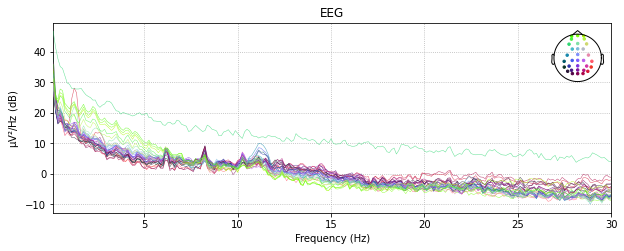

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Chebyshev I bandpass zero-phase (two-pass forward and reverse) non-causal filter:


ValueError: Passband must lie strictly inside stopband or vice versa

In [17]:
# BP filtering
low = .1
high = 30.
iir_params = dict(order=8, ftype='butter', output='sos')
#iir_params = dict(ftype='cheby1',  gpass=3, gstop=20, output='sos')

filt = raws.copy()
#picks = mne.pick_types(raws.info, eeg=True, bio=False,stim=False)
raws.plot_psd(fmin=low,fmax=high,average=False)
filt = filt.filter(low, high, method='iir',iir_params=iir_params)
filt.plot_psd(fmin=low,fmax=high,average=False)

#checbyshev 
#cheby2(N=1, rs, Wn, btype='low', analog=False, output='ba', fs=None)

#optional notch
#filt = filt.notch_filter(freqs=[6,8],fir_design='firwin',picks=picks) #only if some strong artifacts are present
#filt.plot_psd(fmin=low,fmax=high,average=False)

In [11]:
# find events
events = find_events(filt,initial_event=True,stim_channel='Stim')

# downsampling
#raw_resampled, events_resampled = filt.copy().resample(high, npad='auto', events=events)
#print(events_resampled)

# epoch data based on events
epochs = Epochs(filt, 
                events=events, 
                event_id=event_id,
                tmin=-0.2, 
                tmax= 0.8, 
                baseline=None,
                decim = np.ceil(sfreq / high).astype(int), #downsampling epochs
                reject={'eeg': 70e-6,'bio': 30e-6}, #100e-6
                preload=True,verbose=False, 
                picks=list(range(len(ch_names)-1)))

# print the % of dropped samples
the_drop = (1 - len(epochs.events)/len(events)) * 100
print('sample drop %: ', the_drop)





# plot erp conditions per channel
#if len(epochs.events)>0:
#    fig, ax = plot_conditions(epochs,
#                              chan_num=len(ch_names)-2,
#                              conditions=event_id,
#                              ci=97.5, 
#                              n_boot=1000, 
#                              title='',
#                              diff_waveform=(1,2),# diff waveform between target and non target
#                              ylim = (-1,1)
#                             )
#    plt.show()

800 events found
Event IDs: [1 2 3]


C:\Users\pierrecu\AppData\Local\Temp/ipykernel_28456/3015085357.py:9: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=9 parameter will result in a sampling frequency of 28.4444 Hz, which can cause aliasing artifacts.
  epochs = Epochs(filt,


sample drop %:  87.625
